# **Estimation of water quality in Hong Kong using Sentinel-2 images in GEE and artificial neural network (ANN) in Google Colab environment**

This is the second part of python codes used in the article. The codes are tested inside Google Colab environment using Hong Kong water as the study area.

**Import required libraries & Initialize Google Earth Engine session**

In [ ]:
import ee
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
ee.Authenticate()
ee.Initialize()

# Step 1 - Match image data & in-situ station data

Sun glint correction & water mask are performed to each image in this step

In [ ]:
# Load image data & in-situ station data
assetList = ee.data.getList({'id':"users/khoyinivan/S2_Py6S_mask_m"})
url = 'https://raw.githubusercontent.com/ivanhykwong/Marine-Water-Quality-Time-Series-HK/main/MarineQuality_2015-2020.csv'
station_list = ['TM2','TM3','TM4','TM5','TM6','TM7','TM8','SM1','SM2','SM3','SM4','SM5','SM6','SM7','SM9','SM10','SM11',
                'SM12','SM13','SM17','SM18','SM19','SM20','PM1','PM2','PM3','PM4','PM6','PM7','PM8','PM9','PM11','JM3',
                'JM4','DM1','DM2','DM3','DM4','DM5','NM1','NM2','NM3','NM5','NM6','NM8','MM1','MM2','MM3','MM4','MM5',
                'MM6','MM7','MM8','MM13','MM14','MM15','MM16','MM17','MM19','WM1','WM2','WM3','WM4','EM1','EM2','EM3',
                'VM1','VM2','VM4','VM5','VM6','VM7','VM8','VM12','VM14','VM15']
df_url = pd.read_csv(url)
df_url = df_url[df_url['Station'].isin(station_list)]
print(assetList)
print(len(assetList))
aoi = ee.Geometry.Polygon([[[113.800, 22.570],[113.800, 22.120],[114.514, 22.120],[114.514, 22.570]]])
df_data = pd.DataFrame()

for i in range(len(assetList)):
  # Extract image date
  assetid = assetList[i]['id']
  print(assetid)
  d1 = ee.Image(assetid)
  d1_date = d1.date().format('yyyy-MM-dd')
  print(d1_date.getInfo())

  # sun glint correction by subtracting half of B11 from all bands
  # https://www.mdpi.com/2072-4292/1/4/697/htm
  # https://eatlas.org.au/data/uuid/2932dc63-9c9b-465f-80bf-09073aacaf1c
  swir_half = d1.select('B11').multiply(0.5)
  d1 = d1.subtract(swir_half)

  # water mask using MNDWI
  green = d1.select('B3')
  ndwi = d1.expression('(GREEN - SWIR) / (GREEN + SWIR)', {'GREEN': d1.select('B3'), 'SWIR': d1.select('B11')})
  mask = ndwi.gte(0.0).bitwiseAnd(green.gte(0.0)) # MNDWI >= 0
  d1 = d1.updateMask(mask)
  d1 = ee.Image(d1)

  # Find nearest date between image & station data
  df = df_url.copy()
  df['Dates'] = pd.to_datetime(df['Dates'], format='%Y-%m-%d')
  imagedate = datetime.strptime(d1_date.getInfo(), '%Y-%m-%d')
  df['Image_date'] = imagedate
  df['Date_compare'] = abs(df['Dates'] - imagedate)
  df = df.sort_values(by=['Date_compare'])
  df = df.drop_duplicates(subset=['Station'])

  if imagedate.year > 2020:
    continue

  # Match image & station data, extract values to dataframe
  pts = ee.FeatureCollection("users/khoyinivan/MonitoringStation_wgs84_76")
  pt_list = pts.toList(pts.size())
  df[['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']] = np.nan
  for pt in range(pt_list.length().getInfo()):
    pt1 = ee.Feature(pt_list.get(pt))
    pt1_buf = pt1.buffer(20)
    s2_dict = d1.reduceRegion(ee.Reducer.mean(), pt1_buf.geometry()).getInfo()
    n = pt1_buf.getInfo()['properties']['WaterStati']
    for b in ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']:
      df.loc[df['Station'] == n, b] = s2_dict[b]
  df = df.dropna(subset = ['B2'])
  df['n'] = df.shape[0]
  print(df.shape)

  # Combine all image dates
  df_data = pd.concat([df_data, df])

# Export tables
df_data.to_csv('df_data.csv')

This block is written for inputing csv file as the data, skip this block if the dataframe is already loaded

In [ ]:
# for inputing csv file as the data, skip this block if the dataframe is already loaded
df_data = pd.read_csv('df_data.csv')
df_data['Image_date'] = pd.to_datetime(df_data['Image_date'], format='%Y-%m-%d')
df_data['Date_compare'] = pd.to_timedelta(df_data['Date_compare'])
df_data = df_data.drop(columns=['Unnamed: 0'])

# Step 2 - Extract observations & create variables

Extract observations with ≤1 day difference; remove outliers & compute band combinations

In [ ]:
# Extract observations with ≤1 day difference

max_day_diff = 1

df = df_data[['Image_date', 'Dates', 'Date_compare', 'n',
              '5-day Biochemical Oxygen Demand mg_L', 'Ammonia Nitrogen mg_L', 'Chlorophyll-a ug_L', 'Dissolved Oxygen mg_L',
              'E. coli cfu_100mL', 'Faecal Coliforms cfu_100mL', 'Nitrate Nitrogen mg_L', 'Nitrite Nitrogen mg_L',
              'Orthophosphate Phosphorus mg_L', 'pH', 'Salinity psu', 'Secchi Disc Depth M', 'Silica mg_L',
              'Suspended Solids mg_L', 'Temperature C', 'Total Inorganic Nitrogen mg_L', 'Total Kjeldahl Nitrogen mg_L',
              'Total Nitrogen mg_L', 'Total Phosphorus mg_L', 'Turbidity NTU', 'Unionised Ammonia mg_L', 'Volatile Suspended Solids mg_L',
              'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']].copy()

df = df.rename(columns={'Image_date': 'Image_Date', 'Dates': 'Station_Date',
                        '5-day Biochemical Oxygen Demand mg_L': 'BOD', 'Ammonia Nitrogen mg_L': 'AmNi', 'Chlorophyll-a ug_L': 'Chla', 'Dissolved Oxygen mg_L': 'DO',
                        'E. coli cfu_100mL': 'Ecoli', 'Faecal Coliforms cfu_100mL': 'FC', 'Nitrate Nitrogen mg_L': 'NitraNi', 'Nitrite Nitrogen mg_L': 'NitriNi',
                        'Orthophosphate Phosphorus mg_L': 'OrPh', 'pH': 'pH', 'Salinity psu': 'Sal', 'Secchi Disc Depth M': 'SDD', 'Silica mg_L': 'Si',
                        'Suspended Solids mg_L': 'SS', 'Temperature C': 'Temp', 'Total Inorganic Nitrogen mg_L': 'TIN', 'Total Kjeldahl Nitrogen mg_L': 'TKN',
                        'Total Nitrogen mg_L': 'ToNi', 'Total Phosphorus mg_L': 'ToPh', 'Turbidity NTU': 'Tur', 'Unionised Ammonia mg_L': 'UnAm', 'Volatile Suspended Solids mg_L': 'VSS'})

df['Date_compare'] = pd.to_numeric(df['Date_compare'].dt.days)
df['Image_Year'] = pd.DatetimeIndex(df['Image_Date']).year

df = df[(df['Date_compare'] <= max_day_diff) & (df['n'] >= 10)].copy().drop(columns=['Image_Date', 'Station_Date', 'Date_compare', 'n'])

# Remove outlier using Tukey’s fences method

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A']].any(axis=1)]

# Replace 0 to min/2 (avoid inf errors during evaluation)

wq = ['BOD', 'AmNi', 'Chla', 'DO', 'Ecoli', 'FC', 'NitraNi', 'NitriNi', 'OrPh', 'pH', 'Sal', 'SDD', 'Si', 'SS', 'Temp', 'TIN', 'TKN', 'ToNi', 'ToPh', 'Tur', 'UnAm', 'VSS']
for a in wq:
  df[a]=df[a].replace(0, np.NaN)
  df[a]=df[a].replace(np.NaN,df[a].min()/2)
df

In [ ]:
# Create independent variables

bands = ['B' + str(b) for b in [*range(1,8),'8A',11,12]]
wl = [443,490,560,665,705,740,783,865,1610,2190]  #wavelength in nm

# Multiply 10
for i in bands:
  df[i] = df[i]*10

# Square and cubic
for i in bands:
  df[i+'_2'] = df[i]**2
  df[i+'_3'] = df[i]**3

# Two-band ratio
for i in bands:
  for j in bands:
    if (i != j) & (i < j):
      df['NR_'+i+j] = ((df[i] - df[j]) / (df[i] + df[j])).clip(lower=-1.0, upper=1.0)

# Three-band ratio
for i in range(0,10):
  for j in range(0,10):
    for k in range(0,10):
      if (j == i+1) & (k == j+1):
        df['TB_'+bands[i]+bands[j]+bands[k]] = (((1/df[bands[i]]) - (1/df[bands[j]])) * df[bands[k]]).clip(lower=-1.0, upper=1.0)

# Line height algorithm
for i in range(0,10):
  for j in range(0,10):
    for k in range(0,10):
      if (j == i+1) & (k == j+1):
        df['LH_'+bands[i]+bands[j]+bands[k]] = df[bands[j]] - df[bands[i]] - ((df[bands[k]] - df[bands[i]]) * ((wl[j]-wl[i])/(wl[k]-wl[i])))

df.to_csv('df_data_filter.csv')

This block is written for inputing csv file as the data, skip this block if the dataframe is already loaded

In [ ]:
# for inputing csv file as the data, skip this block if the dataframe is already loaded
df = pd.read_csv('df_data_filter.csv')
df = df.drop(columns=['Unnamed: 0'])
wq = ['BOD', 'AmNi', 'Chla', 'DO', 'Ecoli', 'FC', 'NitraNi', 'NitriNi', 'OrPh', 'pH', 'Sal', 'SDD', 'Si', 'SS', 'Temp', 'TIN', 'TKN', 'ToNi', 'ToPh', 'Tur', 'UnAm', 'VSS']

# Step 3 - Train artificial neural network (ANN) models

Include selection of optimal variables through cross-validations; Based on GridSearchCV and MLPRegressor function in Scikit-learn

In [ ]:
# Define train and test datasets

df_train = df[df['Image_Year'] <= 2019].drop(columns=['Image_Year']).copy()
df_test = df[df['Image_Year'] == 2020].drop(columns=['Image_Year']).copy()
X_train = df_train.drop(columns = wq)
X_test = df_test.drop(columns = wq)

In [ ]:
# Define ANN function based on MLPRegressor
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised

def ANN(df_train, X_train, wq_name, first, seed):
  print('seed:' + str(seed))
  print('var:' + str(first))
  print(wq_name)
  c = df_train.corr().copy()
  c = c[wq_name][22:113]
  c = abs(c).sort_values(ascending=False)[0:first]
  var = c.index.tolist()

  X_train2 = X_train[var]
  X_test2 = X_test[var]
  Y_train = df_train[wq_name]
  Y_test = df_test[wq_name]

  hidden_layer_sizes = [2,4,5,6,8,10,(2,2),(4,4),(5,5),(6,6),(8,8),(10,10)]
  tuned_parameters = {'hidden_layer_sizes': hidden_layer_sizes, 'alpha': 10.0 ** -np.arange(1, 7)}
  clf = GridSearchCV(MLPRegressor(random_state=seed,activation='logistic', solver='lbfgs', max_iter=10000, early_stopping=True),
                     param_grid=tuned_parameters, scoring='r2', verbose=1, cv=5)
  clf.fit(X_train2, Y_train)
  nvar = len(var)
  best_layer = clf.best_estimator_.hidden_layer_sizes
  best_alpha = clf.best_estimator_.alpha

  regr = MLPRegressor(random_state=seed, hidden_layer_sizes=best_layer, alpha=best_alpha, activation='logistic', solver='lbfgs', max_iter=10000, early_stopping=True).fit(X_train2, Y_train)

  r_squared = regr.score(X_train2, Y_train)
  adjusted_r_squared = 1 - (1-r_squared)*(len(Y_train)-1)/(len(Y_train)-X_train2.shape[1]-1)

  # Evaluate model
  Y_train_pred = regr.predict(X_train2)
  Y_train_pred[Y_train_pred<0]=0.0
  corr_model = np.corrcoef(Y_train, Y_train_pred)[0, 1]
  rmse = mean_squared_error(Y_train, Y_train_pred, squared=False)
  mae = mean_absolute_error(Y_train, Y_train_pred)
  smape = np.mean(2*(np.abs(Y_train_pred - Y_train))/(np.abs(Y_train)+np.abs(Y_train_pred)))
  print(wq_name + ': ' + str(best_layer) + ', alpha: ' + str(best_alpha) + ', best_score: ' + str(clf.best_score_) + ', R2: ' + str(r_squared) + ', RMSE: ' + str(rmse))

  # Test model
  Y_test_pred = regr.predict(X_test2)
  Y_test_pred[Y_test_pred<0]=0.0
  r_squared_test = regr.score(X_test2, Y_test)
  corr_test = np.corrcoef(Y_test, Y_test_pred)[0, 1]
  rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
  mae_test = mean_absolute_error(Y_test, Y_test_pred)
  smape_test = np.mean(2*(np.abs(Y_test_pred - Y_test))/(np.abs(Y_test)+np.abs(Y_test_pred)))
  print(wq_name + ': r_squared_test: ' + str(r_squared_test) + ', rmse_test: ' + str(rmse_test) +  ', smape_test: ' + str(smape_test))

  ANN_df = pd.DataFrame({'WQ': [wq_name], 'nvar':[nvar], 'var':[var], 'random_state':[seed],
                         'best_layer':[best_layer], 'best_alpha':[best_alpha], 'best_score':[clf.best_score_],
                         'r2': [r_squared], 'adjusted_r2': [adjusted_r_squared], 'corr_model': [corr_model],
                         'rmse': [rmse], 'mae': [mae], 'smape': [smape],
                         'r2_test': [r_squared_test], 'corr_test': [corr_test],
                         'rmse_test': [rmse_test], 'mae_test': [mae_test], 'smape_test': [smape_test]})
  return(ANN_df)

In [ ]:
# Apply ANN function to all water quality parameters
# this process is very time-consuming, reduce the number of wq parameters, reduce the cross-validation variables, or use parallel sessions

wq = ['BOD', 'AmNi', 'Chla', 'DO', 'Ecoli', 'FC', 'NitraNi', 'NitriNi', 'OrPh', 'pH', 'Sal', 'SDD', 'Si', 'SS', 'Temp', 'TIN', 'TKN', 'ToNi', 'ToPh', 'Tur', 'UnAm', 'VSS']
ANN_result_list = [ANN(df_train, X_train, wq_name=value, first=f, seed=seed) for value in wq for f in range(4,13) for seed in range(1,11)]
ANN_result = pd.concat(ANN_result_list)

Example output
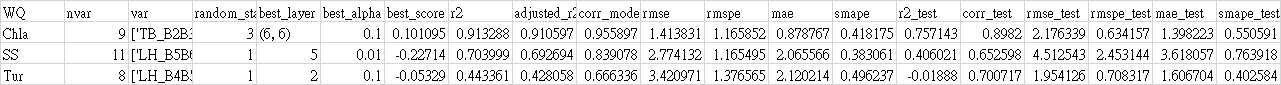

# Step 4 - Apply ANN models to all images

Output images are exported to image collections in GEE

In [ ]:
# Choose the optimal model according to the training results in previous step
# Obtain model parameters (first, seed, best_layer and best_alpha) that were used to create the optimal model (see Example Output above)
# Then obtain weights of each neuron (regr_int and regr_coef) from the model parameters

# Chla
wq_name='Chla'
first=9
seed=3
best_layer=(6,6)
best_alpha=0.1
activation='logistic'
c = df_train.corr().copy()
c = c[wq_name][22:113]
c = abs(c).sort_values(ascending=False)[0:first]
var = c.index.tolist()
X_train2 = X_train[var]
X_test2 = X_test[var]
Y_train = df_train[wq_name]
Y_test = df_test[wq_name]

regr = MLPRegressor(random_state=seed, hidden_layer_sizes=best_layer, alpha=best_alpha, activation=activation, solver='lbfgs', max_iter=10000, early_stopping=True).fit(X_train2, Y_train)
regr_int = regr.intercepts_
print(regr_int)
regr_coef = regr.coefs_
print(regr_coef)

# SS
wq_name='SS'
first=11
seed=1
best_layer=5
best_alpha=0.01
activation='logistic'
c = df_train.corr().copy()
c = c[wq_name][22:113]
c = abs(c).sort_values(ascending=False)[0:first]
var = c.index.tolist()
X_train2 = X_train[var]
X_test2 = X_test[var]
Y_train = df_train[wq_name]
Y_test = df_test[wq_name]

regr = MLPRegressor(random_state=seed, hidden_layer_sizes=best_layer, alpha=best_alpha, activation=activation, solver='lbfgs', max_iter=10000, early_stopping=True).fit(X_train2, Y_train)
regr_int = regr.intercepts_
print(regr_int)
regr_coef = regr.coefs_
print(regr_coef)

# Tur
wq_name='Tur'
first=8
seed=1
best_layer=2
best_alpha=0.1
activation='logistic'
c = df_train.corr().copy()
c = c[wq_name][22:113]
c = abs(c).sort_values(ascending=False)[0:first]
var = c.index.tolist()
X_train2 = X_train[var]
X_test2 = X_test[var]
Y_train = df_train[wq_name]
Y_test = df_test[wq_name]

regr = MLPRegressor(random_state=seed, hidden_layer_sizes=best_layer, alpha=best_alpha, activation=activation, solver='lbfgs', max_iter=10000, early_stopping=True).fit(X_train2, Y_train)
regr_int = regr.intercepts_
print(regr_int)
regr_coef = regr.coefs_
print(regr_coef)

In [ ]:
# Apply ANN model to entire image collection to estimate Chla

assetList = ee.data.getList({'id':"users/khoyinivan/S2_Py6S_mask_m"})
print(assetList)
print(len(assetList))
aoi = ee.Geometry.Polygon([[[113.800, 22.570],[113.800, 22.120],[114.514, 22.120],[114.514, 22.570]]])

for i in range(len(assetList)):
  assetid = assetList[i]['id']
  print(assetid)
  d1 = ee.Image(assetid)
  d1_date = d1.date().format('yyyy-MM-dd')
  print(d1_date.getInfo())
  imagedate = datetime.strptime(d1_date.getInfo(), '%Y-%m-%d')

  # sun glint correction & water mask
  swir_half = d1.select('B11').multiply(0.5)
  d1 = d1.subtract(swir_half)
  ndwi = d1.expression('(GREEN - NIR) / (GREEN + NIR)', {'GREEN': d1.select('B3'), 'NIR': d1.select('B8')})
  green = d1.select('B3')
  mask = ndwi.gte(0.0).bitwiseAnd(green.gte(0.0)) # NDWI >= 0
  d1 = d1.updateMask(mask)
  d1 = ee.Image(d1)

  # Chla
  name = ('Chla' + d1_date.getInfo()).replace('-','')
  regr_int = [([ 3.20462862, -4.79607408,  3.72196477,  4.01253827,  2.75393548, 0.16435048]),
              ([-8.74146412,  1.66061145,  0.35839572, -4.36972238,  2.15743342, -1.37527732]),
              ([-0.08353174])]
  # Var: ['TB_B2B3B4','LH_B3B4B5','LH_B1B2B3','LH_B7B8AB11','B2','NR_B2B3','B2_2','B8A_3','B1']
  # wl = [443,490,560,665,705,740,783,865,1610,2190]
  regr_coef = [([[-6.84163335e+00,  9.11557386e-06,  1.19411541e+00,1.21073081e+00,  1.17434541e+00,  8.92068972e+00],
          [ 1.06607504e-01, -1.74092425e-05,  2.85270757e-01, 3.47071654e+00,  6.96241402e+00, -3.52038843e+00],
          [ 4.29869179e+00,  1.02256279e-05,  2.65460603e+00, 1.74870671e+00, -3.90495929e+00, -4.54783495e-01],
          [ 1.17519063e+01,  4.75687333e-06,  6.04921374e-02, -5.21168117e+00, -2.80664876e+00,  1.13555655e+00],
          [-8.89242522e-01, -5.21662319e-08, -1.27341490e+00, -4.42972054e+00, -1.33156806e+01, -4.00857609e+00],
          [ 6.44798755e+00, -2.83891110e-05, -2.00038534e+00, 1.36985042e+01, -3.79913833e+00,  3.92121192e+00],
          [ 5.14241155e+00, -6.06040494e-06, -2.24315388e+00, -5.67994435e+00, -2.52787495e+00, -3.26207134e+00],
          [ 6.30920542e+00,  1.23064247e-05, -3.37502754e-02, 2.83332915e-01,  3.75643313e+00, -4.06294587e-01],
          [-8.35038133e+00, -3.68571701e-05, -5.79237965e+00, 1.48052989e+00, -9.32440766e+00, -3.83986207e+00]]),
      ([[-2.94657990e+00, -1.42551128e+01, -3.45316647e+00, -1.09401098e+01, -7.62867142e+00, -1.62820122e+00],
          [-6.15294982e-04, -2.50226568e-04,  2.28071787e-04, 6.44446416e-05,  1.58399756e-04,  1.03145638e-04],
          [ 2.12536696e-01, -6.21840984e+00,  2.45608299e+00, 2.26263141e+00,  1.26472416e+00,  2.88959971e-01],
          [ 5.46308778e-03,  6.95531564e+00, -1.77089020e+00, 1.00952176e+01, -2.91392188e+00, -3.57717559e+00],
          [ 8.38737781e+00, -6.48407937e-02, -1.47897332e+00, 1.24298506e+01,  9.11814110e+00,  3.07254104e+00],
          [ 6.86841847e+00,  7.39998611e+00,  2.06500733e+00, -5.27889971e+00,  5.32904476e+00,  3.87425016e+00]]),
      ([[13.20989264], [20.96326861], [ 7.10314308], [12.19847729], [-8.33632165], [ 8.97286496]])]
  B1 = d1.select('B1').multiply(10).rename('0')
  B2 = d1.select('B2').multiply(10).rename('0')
  B3 = d1.select('B3').multiply(10).rename('0')
  B4 = d1.select('B4').multiply(10).rename('0')
  B5 = d1.select('B5').multiply(10).rename('0')
  B6 = d1.select('B6').multiply(10).rename('0')
  B7 = d1.select('B7').multiply(10).rename('0')
  B8A = d1.select('B8A').multiply(10).rename('0')
  B11 = d1.select('B11').multiply(10).rename('0')
  B12 = d1.select('B12').multiply(10).rename('0')

  V1 = d1.expression('((1/B2)-(1/B3))*B4',{'B2': B2, 'B3': B3, 'B4': B4}).rename('0')
  V1 = V1.gte(-1.0).multiply(V1).subtract(V1.lt(-1.0))
  V1 = V1.lte(1.0).multiply(V1).add(V1.gt(1.0)).rename('0')
  V2 = d1.expression('B4-B3-(B5-B3)*((665-560)/(705-560))',{'B3': B3, 'B4': B4, 'B5': B5}).rename('0')
  V3 = d1.expression('B2-B1-(B3-B1)*((490-443)/(560-443))',{'B1':B1, 'B2': B2, 'B3': B3}).rename('0')
  V4 = d1.expression('B8A-B7-(B11-B7)*((865-783)/(1610-783))',{'B7': B7, 'B8A': B8A, 'B11': B11}).rename('0')
  V5 = B2
  V6 = d1.expression('(B2-B3)/(B2+B3)',{'B2': B2, 'B3': B3}).rename('0')
  V6 = V6.gte(-1.0).multiply(V6).subtract(V6.lt(-1.0))
  V6 = V6.lte(1.0).multiply(V6).add(V6.gt(1.0)).rename('0')
  V7 = B2.multiply(B2).rename('0')
  V8 = B8A.multiply(B8A).multiply(B8A).rename('0')
  V9 = B1

  N1 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][0], 'C1': regr_coef[0][0][0], 'C2': regr_coef[0][1][0], 'C3': regr_coef[0][2][0],
      'C4': regr_coef[0][3][0], 'C5': regr_coef[0][4][0], 'C6': regr_coef[0][5][0],
      'C7': regr_coef[0][6][0], 'C8': regr_coef[0][7][0], 'C9': regr_coef[0][8][0],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1) #sigmoid
  # N1 = N1.gte(0.0).multiply(N1) #relu

  N2 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][1], 'C1': regr_coef[0][0][1], 'C2': regr_coef[0][1][1], 'C3': regr_coef[0][2][1],
      'C4': regr_coef[0][3][1], 'C5': regr_coef[0][4][1], 'C6': regr_coef[0][5][1],
      'C7': regr_coef[0][6][1], 'C8': regr_coef[0][7][1], 'C9': regr_coef[0][8][1],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N3 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][2], 'C1': regr_coef[0][0][2], 'C2': regr_coef[0][1][2], 'C3': regr_coef[0][2][2],
      'C4': regr_coef[0][3][2], 'C5': regr_coef[0][4][2], 'C6': regr_coef[0][5][2],
      'C7': regr_coef[0][6][2], 'C8': regr_coef[0][7][2], 'C9': regr_coef[0][8][2],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N4 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][3], 'C1': regr_coef[0][0][3], 'C2': regr_coef[0][1][3], 'C3': regr_coef[0][2][3],
      'C4': regr_coef[0][3][3], 'C5': regr_coef[0][4][3], 'C6': regr_coef[0][5][3],
      'C7': regr_coef[0][6][3], 'C8': regr_coef[0][7][3], 'C9': regr_coef[0][8][3],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N5 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][4], 'C1': regr_coef[0][0][4], 'C2': regr_coef[0][1][4], 'C3': regr_coef[0][2][4],
      'C4': regr_coef[0][3][4], 'C5': regr_coef[0][4][4], 'C6': regr_coef[0][5][4],
      'C7': regr_coef[0][6][4], 'C8': regr_coef[0][7][4], 'C9': regr_coef[0][8][4],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N6 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][5], 'C1': regr_coef[0][0][5], 'C2': regr_coef[0][1][5], 'C3': regr_coef[0][2][5],
      'C4': regr_coef[0][3][5], 'C5': regr_coef[0][4][5], 'C6': regr_coef[0][5][5],
      'C7': regr_coef[0][6][5], 'C8': regr_coef[0][7][5], 'C9': regr_coef[0][8][5],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N21 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][0], 'C1': regr_coef[1][0][0], 'C2': regr_coef[1][1][0], 'C3': regr_coef[1][2][0],
      'C4': regr_coef[1][3][0], 'C5': regr_coef[1][4][0], 'C6': regr_coef[1][5][0],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N22 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][1], 'C1': regr_coef[1][0][1], 'C2': regr_coef[1][1][1], 'C3': regr_coef[1][2][1],
      'C4': regr_coef[1][3][1], 'C5': regr_coef[1][4][1], 'C6': regr_coef[1][5][1],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N23 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][2], 'C1': regr_coef[1][0][2], 'C2': regr_coef[1][1][2], 'C3': regr_coef[1][2][2],
      'C4': regr_coef[1][3][2], 'C5': regr_coef[1][4][2], 'C6': regr_coef[1][5][2],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N24 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][3], 'C1': regr_coef[1][0][3], 'C2': regr_coef[1][1][3], 'C3': regr_coef[1][2][3],
      'C4': regr_coef[1][3][3], 'C5': regr_coef[1][4][3], 'C6': regr_coef[1][5][3],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N25 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][4], 'C1': regr_coef[1][0][4], 'C2': regr_coef[1][1][4], 'C3': regr_coef[1][2][4],
      'C4': regr_coef[1][3][4], 'C5': regr_coef[1][4][4], 'C6': regr_coef[1][5][4],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N26 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][5], 'C1': regr_coef[1][0][5], 'C2': regr_coef[1][1][5], 'C3': regr_coef[1][2][5],
      'C4': regr_coef[1][3][5], 'C5': regr_coef[1][4][5], 'C6': regr_coef[1][5][5],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  d1_predict = d1.expression('Int+C1*N21+C2*N22+C3*N23+C4*N24+C5*N25+C6*N26',{
      'Int': regr_int[2][0], 'C1': regr_coef[2][0][0], 'C2': regr_coef[2][1][0], 'C3': regr_coef[2][2][0],
      'C4': regr_coef[2][3][0], 'C5': regr_coef[2][4][0], 'C6': regr_coef[2][5][0],
      'N21': N21, 'N22': N22, 'N23': N23, 'N24': N24, 'N25': N25, 'N26': N26
  })

  d1_predict = d1_predict.rename(name).set('system:time_start', ee.Date(d1_date).millis())

  task = ee.batch.Export.image.toAsset(image=d1_predict, description=name, assetId = 'users/khoyinivan/S2_Chla_ANN/' + name, scale = 10, region = aoi)
  task.start()

In [ ]:
# Apply ANN model to entire image collection to estimate Suspended Solids

assetList = ee.data.getList({'id':"users/khoyinivan/S2_Py6S_mask_m"})
print(assetList)
print(len(assetList))
aoi = ee.Geometry.Polygon([[[113.800, 22.570],[113.800, 22.120],[114.514, 22.120],[114.514, 22.570]]])

for i in range(len(assetList)):
  assetid = assetList[i]['id']
  print(assetid)
  d1 = ee.Image(assetid)
  d1_date = d1.date().format('yyyy-MM-dd')
  print(d1_date.getInfo())
  imagedate = datetime.strptime(d1_date.getInfo(), '%Y-%m-%d')

  # sun glint correction & water mask
  swir_half = d1.select('B11').multiply(0.5)
  d1 = d1.subtract(swir_half)
  ndwi = d1.expression('(GREEN - NIR) / (GREEN + NIR)', {'GREEN': d1.select('B3'), 'NIR': d1.select('B8')})
  green = d1.select('B3')
  mask = ndwi.gte(0.0).bitwiseAnd(green.gte(0.0)) # NDWI >= 0
  d1 = d1.updateMask(mask)
  d1 = ee.Image(d1)

  # SS
  name = ('SS' + d1_date.getInfo()).replace('-','')
  regr_int = [[12.55921704, -13.73353476, -1.56213489, -15.96103343, -2.74424462],
            [5.20100899]]
  # Var: ['LH_B5B6B7', 'LH_B4B5B6', 'B5_3', 'B5_2', 'B4_2', 'B4_3', 'B4', 'B5', 'B3_2', 'B3_3', 'B3']
  # wl = [443,490,560,665,705,740,783,865,1610,2190]
  regr_coef = [[[0.00315948251, -32.9780628, -5.07213985, 7.38647208, -28.4785664],
        [-0.000983638194, 25.9594867, 9.85539378, -15.2927115, -13.2072681],
        [-0.00164435665, 36.9788436, 3.02589409, -2.5088956, -1.45870294],
        [-0.00471352417, 20.1816497, 3.80586779, -7.21854322, -1.17430456],
        [-0.00635952648, -2.15180342, -5.37556561, 5.24388819, 10.5224534],
        [-0.00342851065, -8.5595385, 2.34126206, 4.644868, 1.65118437],
        [-0.010480811, 5.77984149, 36.2489087, 3.7447754, 28.9145655],
        [-0.00881720748, -35.9948876, 12.793081, -15.1404911, 15.8537979],
        [-0.0146337387, 7.69747295, -17.8781654, 13.9578202, -9.13328681],
        [-0.0106495051, -13.5599014, -0.717967751, 15.7539373, -14.516977],
        [-0.0179451399, 18.4680285, -1.31164633, 9.56437974, -0.594566828]],
    [[0.00693088504], [60.2560856], [-22.1701438], [2.36782265], [23.713127]]]
  B1 = d1.select('B1').multiply(10).rename('0')
  B2 = d1.select('B2').multiply(10).rename('0')
  B3 = d1.select('B3').multiply(10).rename('0')
  B4 = d1.select('B4').multiply(10).rename('0')
  B5 = d1.select('B5').multiply(10).rename('0')
  B6 = d1.select('B6').multiply(10).rename('0')
  B7 = d1.select('B7').multiply(10).rename('0')
  B8A = d1.select('B8A').multiply(10).rename('0')
  B11 = d1.select('B11').multiply(10).rename('0')
  B12 = d1.select('B12').multiply(10).rename('0')

  V1 = d1.expression('B6-B5-(B7-B5)*((740-705)/(783-705))',{'B5': B5, 'B6': B6, 'B7': B7}).rename('0')
  V2 = d1.expression('B5-B4-(B6-B4)*((705-665)/(740-665))',{'B4': B4, 'B5': B5, 'B6': B6}).rename('0')
  V3 = B5.multiply(B5).multiply(B5).rename('0')
  V4 = B5.multiply(B5).rename('0')
  V5 = B4.multiply(B4).rename('0')
  V6 = B4.multiply(B4).multiply(B4).rename('0')
  V7 = B4
  V8 = B5
  V9 = B3.multiply(B3).rename('0')
  V10 = B3.multiply(B3).multiply(B3).rename('0')
  V11 = B3

  N1 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][0], 'C1': regr_coef[0][0][0], 'C2': regr_coef[0][1][0], 'C3': regr_coef[0][2][0],
      'C4': regr_coef[0][3][0], 'C5': regr_coef[0][4][0], 'C6': regr_coef[0][5][0],
      'C7': regr_coef[0][6][0], 'C8': regr_coef[0][7][0], 'C9': regr_coef[0][8][0],
      'C10': regr_coef[0][9][0], 'C11': regr_coef[0][10][0],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1) #sigmoid

  N2 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][1], 'C1': regr_coef[0][0][1], 'C2': regr_coef[0][1][1], 'C3': regr_coef[0][2][1],
      'C4': regr_coef[0][3][1], 'C5': regr_coef[0][4][1], 'C6': regr_coef[0][5][1],
      'C7': regr_coef[0][6][1], 'C8': regr_coef[0][7][1], 'C9': regr_coef[0][8][1],
      'C10': regr_coef[0][9][1], 'C11': regr_coef[0][10][1],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1)

  N3 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][2], 'C1': regr_coef[0][0][2], 'C2': regr_coef[0][1][2], 'C3': regr_coef[0][2][2],
      'C4': regr_coef[0][3][2], 'C5': regr_coef[0][4][2], 'C6': regr_coef[0][5][2],
      'C7': regr_coef[0][6][2], 'C8': regr_coef[0][7][2], 'C9': regr_coef[0][8][2],
      'C10': regr_coef[0][9][2], 'C11': regr_coef[0][10][2],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1)

  N4 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][3], 'C1': regr_coef[0][0][3], 'C2': regr_coef[0][1][3], 'C3': regr_coef[0][2][3],
      'C4': regr_coef[0][3][3], 'C5': regr_coef[0][4][3], 'C6': regr_coef[0][5][3],
      'C7': regr_coef[0][6][3], 'C8': regr_coef[0][7][3], 'C9': regr_coef[0][8][3],
      'C10': regr_coef[0][9][3], 'C11': regr_coef[0][10][3],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1)

  N5 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][4], 'C1': regr_coef[0][0][4], 'C2': regr_coef[0][1][4], 'C3': regr_coef[0][2][4],
      'C4': regr_coef[0][3][4], 'C5': regr_coef[0][4][4], 'C6': regr_coef[0][5][4],
      'C7': regr_coef[0][6][4], 'C8': regr_coef[0][7][4], 'C9': regr_coef[0][8][4],
      'C10': regr_coef[0][9][4], 'C11': regr_coef[0][10][4],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1)

  d1_predict = d1.expression('Int+C1*N1+C2*N2+C3*N3+C4*N4+C5*N5',{
      'Int': regr_int[1][0], 'C1': regr_coef[1][0][0], 'C2': regr_coef[1][1][0], 'C3': regr_coef[1][2][0],
      'C4': regr_coef[1][3][0], 'C5': regr_coef[1][4][0],
      'N1': N1, 'N2': N2, 'N3': N3, 'N4': N4, 'N5': N5
  })

  d1_predict = d1_predict.rename(name).set('system:time_start', ee.Date(d1_date).millis())

  task = ee.batch.Export.image.toAsset(image=d1_predict, description=name, assetId = 'users/khoyinivan/S2_SS_ANN/' + name, scale = 10, region = aoi)
  task.start()

In [ ]:
# Apply ANN model to entire image collection to estimate Turbidity

assetList = ee.data.getList({'id':"users/khoyinivan/S2_Py6S_mask_m"})
print(assetList)
print(len(assetList))
aoi = ee.Geometry.Polygon([[[113.800, 22.570],[113.800, 22.120],[114.514, 22.120],[114.514, 22.570]]])

for i in range(len(assetList)):
  assetid = assetList[i]['id']
  print(assetid)
  d1 = ee.Image(assetid)
  d1_date = d1.date().format('yyyy-MM-dd')
  print(d1_date.getInfo())
  imagedate = datetime.strptime(d1_date.getInfo(), '%Y-%m-%d')

  # sun glint correction & water mask
  swir_half = d1.select('B11').multiply(0.5)
  d1 = d1.subtract(swir_half)
  ndwi = d1.expression('(GREEN - NIR) / (GREEN + NIR)', {'GREEN': d1.select('B3'), 'NIR': d1.select('B8')})
  green = d1.select('B3')
  mask = ndwi.gte(0.0).bitwiseAnd(green.gte(0.0)) # NDWI >= 0
  d1 = d1.updateMask(mask)
  d1 = ee.Image(d1)

  # Tur
  name = ('Tur' + d1_date.getInfo()).replace('-','')
  regr_int = [[1.03043919, -5.1108822], [26.60795985]]
  # Var: ['LH_B4B5B6', 'LH_B5B6B7', 'LH_B2B3B4', 'B3_3', 'B3_2', 'B5_3', 'B3', 'B5_2']
  # wl = [443,490,560,665,705,740,783,865,1610,2190]
  regr_coef = [[[-24.70594813, 14.37269736],
                [1.01369778, 0.71021701],
                [5.39600925, 7.8477396],
                [-5.40222666, -13.46987698],
                [-3.67650209, 1.77537138],
                [-1.75628292, 6.8203711],
                [5.18825675, 7.52539217],
                [10.51626892, 8.31789011]],
              [[-27.16748834], [16.79998435]]]
  B1 = d1.select('B1').multiply(10).rename('0')
  B2 = d1.select('B2').multiply(10).rename('0')
  B3 = d1.select('B3').multiply(10).rename('0')
  B4 = d1.select('B4').multiply(10).rename('0')
  B5 = d1.select('B5').multiply(10).rename('0')
  B6 = d1.select('B6').multiply(10).rename('0')
  B7 = d1.select('B7').multiply(10).rename('0')
  B8A = d1.select('B8A').multiply(10).rename('0')
  B11 = d1.select('B11').multiply(10).rename('0')
  B12 = d1.select('B12').multiply(10).rename('0')

  V1 = d1.expression('B5-B4-(B6-B4)*((705-665)/(740-665))',{'B4': B4, 'B5': B5, 'B6': B6}).rename('0')
  V2 = d1.expression('B6-B5-(B7-B5)*((740-705)/(783-705))',{'B5': B5, 'B6': B6, 'B7': B7}).rename('0')
  V3 = d1.expression('B3-B2-(B4-B2)*((560-490)/(665-490))',{'B2': B2, 'B3': B3, 'B4': B4}).rename('0')
  V4 = B3.multiply(B3).multiply(B3).rename('0')
  V5 = B3.multiply(B3).rename('0')
  V6 = B5.multiply(B5).multiply(B5).rename('0')
  V7 = B3
  V8 = B5.multiply(B5).rename('0')

  N1 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8',{
      'Int': regr_int[0][0], 'C1': regr_coef[0][0][0], 'C2': regr_coef[0][1][0], 'C3': regr_coef[0][2][0],
      'C4': regr_coef[0][3][0], 'C5': regr_coef[0][4][0], 'C6': regr_coef[0][5][0],
      'C7': regr_coef[0][6][0], 'C8': regr_coef[0][7][0],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8
  }).multiply(-1.0).exp().add(1).pow(-1) #sigmoid

  N2 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8',{
      'Int': regr_int[0][1], 'C1': regr_coef[0][0][1], 'C2': regr_coef[0][1][1], 'C3': regr_coef[0][2][1],
      'C4': regr_coef[0][3][1], 'C5': regr_coef[0][4][1], 'C6': regr_coef[0][5][1],
      'C7': regr_coef[0][6][1], 'C8': regr_coef[0][7][1],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8
  }).multiply(-1.0).exp().add(1).pow(-1)

  d1_predict = d1.expression('Int+C1*N1+C2*N2',{
      'Int': regr_int[1][0], 'C1': regr_coef[1][0][0], 'C2': regr_coef[1][1][0],
      'N1': N1, 'N2': N2
  })

  d1_predict = d1_predict.rename(name).set('system:time_start', ee.Date(d1_date).millis())

  task = ee.batch.Export.image.toAsset(image=d1_predict, description=name, assetId = 'users/khoyinivan/S2_Tur_ANN/' + name, scale = 10, region = aoi)
  task.start()